### Imports and definitions


In [1]:
import io
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import torch
from PIL import Image
from rich import print
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

sns.set_style("darkgrid")

In [2]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content)).convert("RGB")


def generate(images, prompt, processor, model, device, dtype, generation_config):
    inputs = processor(images=images[:2], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(
        device=device, dtype=dtype
    )
    output = model.generate(
        **inputs,
        generation_config=generation_config,
        # this silences "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
        pad_token_id=processor.tokenizer.eos_token_id,
    )[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    return response


def main():
    # step 1: Setup constant
    device = "cuda"
    dtype = torch.float16

    # step 2: Load Processor and Model
    processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
    generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")
    model = AutoModelForCausalLM.from_pretrained(
        "StanfordAIMI/CheXagent-8b", torch_dtype=dtype, trust_remote_code=True
    ).to(device)

    # step 3: Fetch the images
    image_path = "https://upload.wikimedia.org/wikipedia/commons/3/3b/Pleural_effusion-Metastatic_breast_carcinoma_Case_166_%285477628658%29.jpg"
    images = [download_image(image_path)]

    # step 4: Generate the Findings section
    for anatomy in anatomies:
        prompt = f'Describe "{anatomy}"'
        response = generate(images, prompt, processor, model, device, dtype, generation_config)
        print(f"Generating the Findings for [{anatomy}]:")
        print(response)


def plot_img(image, title):
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()

#### `main()` call


In [3]:
# anatomies = [
#     "Airway",
#     "Breathing",
#     "Cardiac",
#     "Diaphragm",
#     "Everything else (e.g., mediastinal contours, bones, soft tissues, tubes, valves, and pacemakers)",
# ]
# main()

### [NIH Chest X-ray dataset](https://www.kaggle.com/datasets/nih-chest-xrays/sample/data)


In [4]:
column_names = ["image_index", "finding_labels", "follow_up_number", "patient_id", "patient_age", "patient_gender", "view_position", "original_image_width", "original_image_height", "original_image_pixel_spacing_x", "original_image_pixel_spacing_y"]  # fmt: skip # nopep8

data = pd.read_csv(
    "/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv",
    names=column_names,
    header=0,
    index_col=False,
)
print(f"Rows: {data.shape[0]:,}\tColumns: {data.shape[1]}")
display(data.head())

Rows: 112,120   Columns: 11

,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_image_width,original_image_height,original_image_pixel_spacing_x,original_image_pixel_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


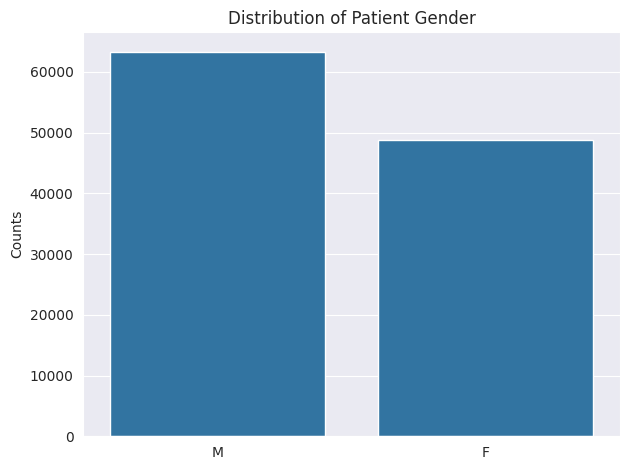

In [5]:
sns.countplot(x=data["patient_gender"])
plt.gca().set(title="Distribution of Patient Gender", xlabel=None, ylabel="Counts")
plt.tight_layout()
plt.show()

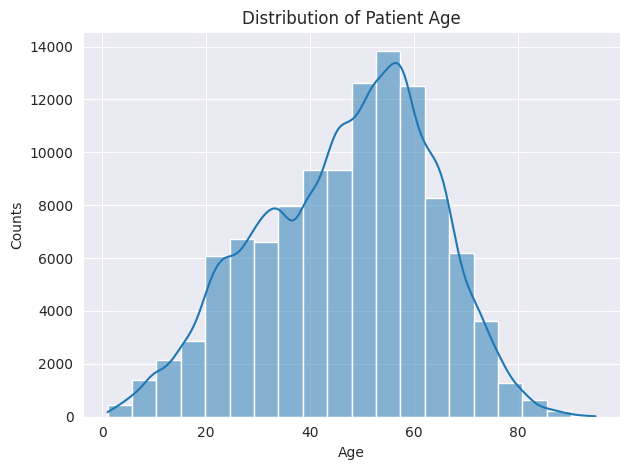

In [6]:
sns.histplot(data=data[data["patient_age"] < 130], x="patient_age", bins=20, kde=True)
plt.gca().set(title="Distribution of Patient Age", xlabel="Age", ylabel="Counts")
plt.tight_layout()
plt.show()

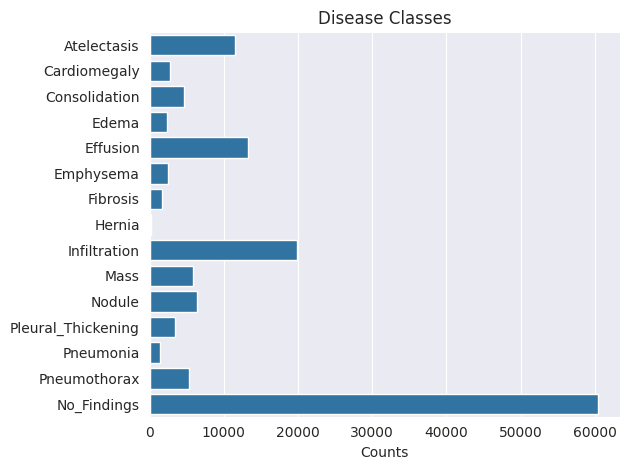

In [7]:
# Create boolean columns for each pathology type
pathology_list = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]  # fmt: skip # nopep8

for pathology in pathology_list:
    data[pathology] = data["finding_labels"].apply(lambda x: 1 if pathology in x else 0)

data["No_Findings"] = data["finding_labels"].apply(lambda x: 1 if "No Finding" in x else 0)

# Sum of values across selected columns and reset index for Seaborn
sum_data = data.iloc[:, 11:].sum().reset_index()
sum_data.columns = ["Feature", "Total"]

sns.barplot(x="Total", y="Feature", data=sum_data)
plt.gca().set(title="Disease Classes", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

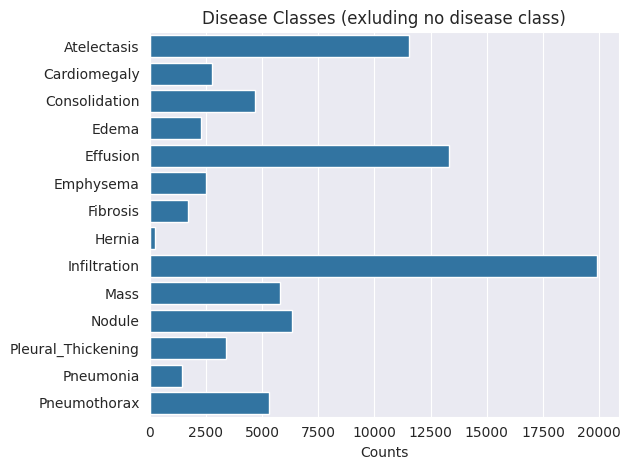

In [8]:
sns.barplot(x="Total", y="Feature", data=sum_data.loc[sum_data["Feature"] != "No_Findings", :])
plt.gca().set(title="Disease Classes (exluding no disease class)", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

In [9]:
# subset: cases with exactly one finding label, first case of each label
subset = data.loc[data.iloc[:, 11:].apply(sum, axis=1) == 1, :].groupby("finding_labels").head(1).copy()

image_dir = "/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data/NIH_Chest_X-ray_Dataset"
subset["image_path"] = subset["image_index"].transform(lambda x: next(Path(image_dir).rglob(x)).as_posix())
display(subset)

,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_image_width,original_image_height,original_image_pixel_spacing_x,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No_Findings,image_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,1,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
19,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,...,0,0,1,0,0,0,0,0,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
25,00000008_002.png,Nodule,2,8,73,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
26,00000009_000.png,Emphysema,0,9,73,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
28,00000011_000.png,Effusion,0,11,75,M,PA,2638,2449,0.143,...,0,0,0,0,0,0,0,0,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
34,00000011_006.png,Atelectasis,6,11,75,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
41,00000013_003.png,Pleural_Thickening,3,13,60,M,AP,2996,2544,0.139,...,0,0,0,0,0,1,0,0,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...
49,00000013_011.png,Pneumothorax,11,13,60,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,/data/irf/ai/tmp_MDR/github/MDR_CheXagent/data...


### `main()` code sections


###### step 1: Setup constant


In [10]:
device = "cuda"
dtype = torch.float16

###### step 2: Load Processor and Model


In [11]:
processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")
model = AutoModelForCausalLM.from_pretrained("StanfordAIMI/CheXagent-8b", torch_dtype=dtype, trust_remote_code=True).to(
    device
)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

###### step 3: Fetch the images


In [12]:
image_path = "https://upload.wikimedia.org/wikipedia/commons/3/3b/Pleural_effusion-Metastatic_breast_carcinoma_Case_166_%285477628658%29.jpg"
images = [download_image(image_path)]
# image_path = subset["image_path"].sample(1).values[0]
# images = [Image.open(image_path).convert("RGB")]

###### step 4: Generate the Findings section


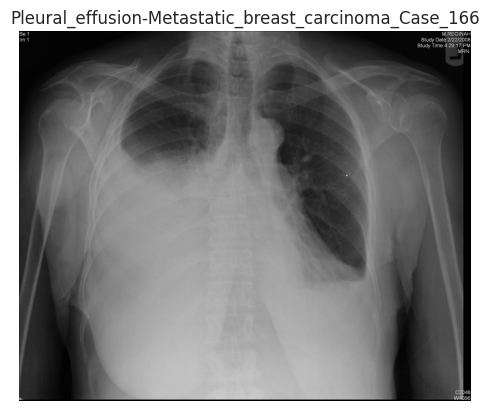

Generating the Findings for [Airway]:

The hilar contours are unremarkable.

Generating the Findings for [Breathing]:

**There is a large right pleural effusion with associated atelectasis.** The left lung is clear. There is no 
pneumothorax.

Generating the Findings for [Cardiac]:

**The cardiac silhouette is enlarged.**

Generating the Findings for [Diaphragm]:

**There is blunting of the right costophrenic angle.**

Generating the Findings for [Everything else (e.g., mediastinal contours, bones, soft tissues, tubes, valves, and 
pacemakers)]:

The mediastinal contours are normal.

In [13]:
warnings.filterwarnings("ignore", category=UserWarning)

anatomies = [
    "Airway",
    "Breathing",
    "Cardiac",
    "Diaphragm",
    "Everything else (e.g., mediastinal contours, bones, soft tissues, tubes, valves, and pacemakers)",
]

plot_img(image=images[0], title="Pleural_effusion-Metastatic_breast_carcinoma_Case_166")

for anatomy in anatomies:
    prompt = f'Describe "{anatomy}"'
    response = generate(images, prompt, processor, model, device, dtype, generation_config)
    print(f"Generating the Findings for [{anatomy}]:")
    print(response)

warnings.resetwarnings()

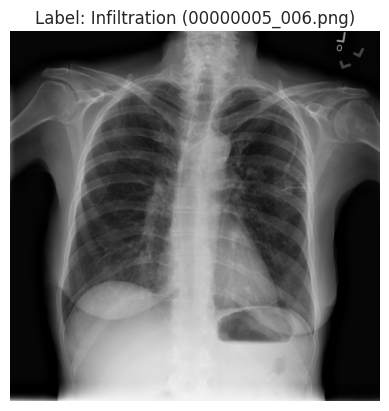

Q: Describe "Airway"

A: The hilar contours are normal.

Q: Describe "Breathing"

A: There is no focal consolidation. There is no pleural effusion or pneumothorax.

Q: Describe "Cardiac"

A: The cardiomediastinal silhouette is normal.

Q: Describe "Diaphragm"

A: **Blunting of the left costophrenic angle suggests a small pleural effusion.**

Q: Describe "Everything else (e.g., mediastinal contours, bones, soft tissues, tubes, valves, and pacemakers)"

A: A left-sided Port-A-Cath terminates at the cavoatrial junction.

----------------------------------------------------------------------------------------------------

In [18]:
warnings.filterwarnings("ignore", category=UserWarning)

anatomies = [
    "Airway",
    "Breathing",
    "Cardiac",
    "Diaphragm",
    "Everything else (e.g., mediastinal contours, bones, soft tissues, tubes, valves, and pacemakers)",
]

for _, row in subset.sample(1).iterrows():
    images = [Image.open(row["image_path"]).convert("RGB")]
    img_name, label = row["image_index"], row["finding_labels"]
    title = f"Label: {label} ({img_name})"
    plot_img(image=images[0], title=title)
    for anatomy in anatomies:
        prompt = f'Describe "{anatomy}"'
        response = generate(images, prompt, processor, model, device, dtype, generation_config)
        print(f"Q: {prompt}\n\nA: {response}\n\n")
    print("-" * 100)

warnings.resetwarnings()

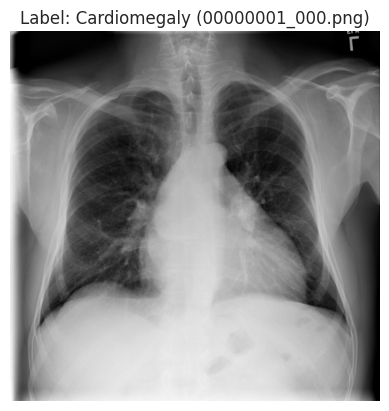

Q: Identify all abnormalities in the given chest X-ray.

A: Enlarged cardiac silhouette, lung opacity

Q: What abnormalities are notable for this patient?

A: Enlarged cardiac silhouette

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Breathing: Lungs] There is no focal consolidation. [Breathing: Pleura] There is no pleural effusion or 
pneumothorax. [Breathing: Lungs] There is no pulmonary edema. [Cardiac: Heart Size] The heart size is normal. 
[Everything else: Mediastinal] The mediastinal contours are normal. [Airway: Hilar Structures] The hilar contours 
are normal.

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

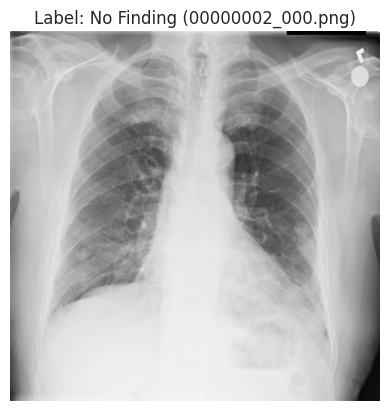

Q: Identify all abnormalities in the given chest X-ray.

A: Enlarged cardiac silhouette, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Enlarged cardiac silhouette, lung opacity, pleural effusion, pulmonary edema/hazy opacity

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Breathing: Lungs] There is no focal consolidation. [Breathing: Pleura] There is no pleural effusion or 
pneumothorax. [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The mediastinal 
contours are normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Lungs] There is no 
pulmonary edema.

Q: Are there any ground glass opacities?

A: Yes

----------------------------------------------------------------------------------------------------

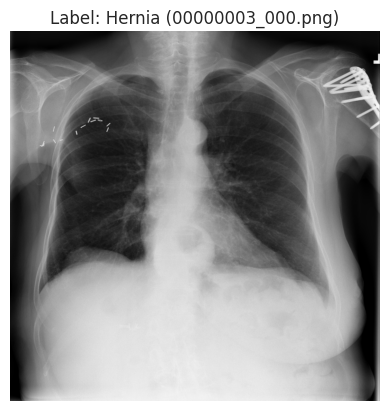

Q: Identify all abnormalities in the given chest X-ray.

A: Atelectasis, enlarged cardiac silhouette, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Atelectasis, enlarged cardiac silhouette, lung opacity, pleural effusion, pleural/parenchymal scarring

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Breathing: Lungs] There is no focal consolidation. [Breathing: Pleura] There is no pleural effusion or 
pneumothorax. [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The mediastinal 
contours are normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Lungs] There is no 
pulmonary edema.

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

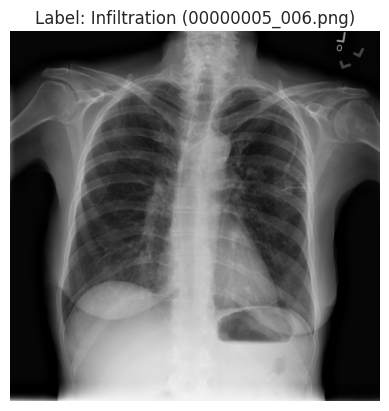

Q: Identify all abnormalities in the given chest X-ray.

A: Atelectasis, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Atelectasis, enlarged cardiac silhouette, lung opacity, pleural effusion, pleural/parenchymal scarring

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Breathing: Lungs] There is no focal consolidation. [Breathing: Pleura] There is no pleural effusion or 
pneumothorax. [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The mediastinal 
contours are normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Lungs] There is no 
pulmonary edema.

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

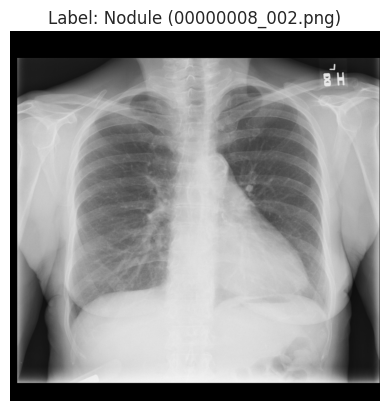

Q: Identify all abnormalities in the given chest X-ray.

A: Enlarged cardiac silhouette, lung opacity

Q: What abnormalities are notable for this patient?

A: Enlarged cardiac silhouette

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Breathing: Lungs] There is no focal consolidation. [Breathing: Pleura] There is no pleural effusion or 
pneumothorax. [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The mediastinal 
contours are normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Lungs] There is no 
pulmonary edema.

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

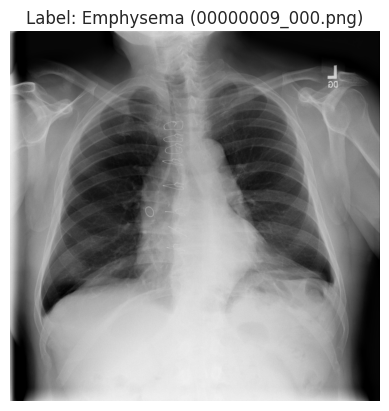

Q: Identify all abnormalities in the given chest X-ray.

A: Atelectasis, enlarged cardiac silhouette, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Atelectasis, enlarged cardiac silhouette, lung opacity, pleural effusion, pleural/parenchymal scarring

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Breathing: Lungs] There is no focal consolidation. [Breathing: Pleura] There is no pleural effusion or 
pneumothorax. [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The mediastinal 
contours are normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Lungs] There is no 
pulmonary edema.

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

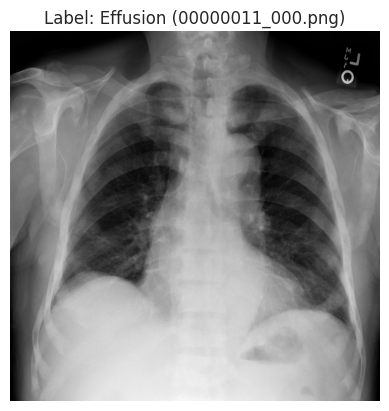

Q: Identify all abnormalities in the given chest X-ray.

A: Enlarged cardiac silhouette, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Enlarged cardiac silhouette, lung opacity, pleural effusion, pulmonary edema/hazy opacity

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Breathing: Lungs] There is no focal consolidation. [Breathing: Pleura] There is no pleural effusion or 
pneumothorax. [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The mediastinal 
contours are normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Lungs] There is no 
pulmonary edema.

Q: Are there any ground glass opacities?

A: Yes

----------------------------------------------------------------------------------------------------

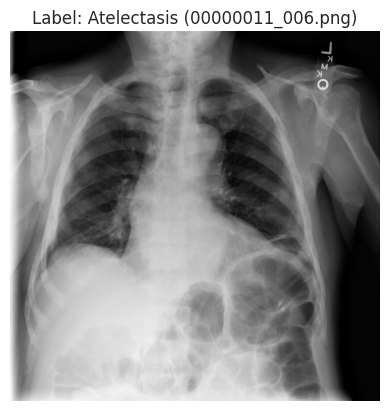

Q: Identify all abnormalities in the given chest X-ray.

A: Atelectasis, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Enlarged cardiac silhouette, lung opacity, pleural effusion, pulmonary edema/hazy opacity

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The mediastinal contours are 
normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Lungs] The pulmonary vasculature is 
normal. [Breathing: Lungs] The lungs are clear. [Breathing: Pleura] No pleural effusion or pneumothorax is seen. 
[Everything else: Bones] There are no acute osseous abnormalities.

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

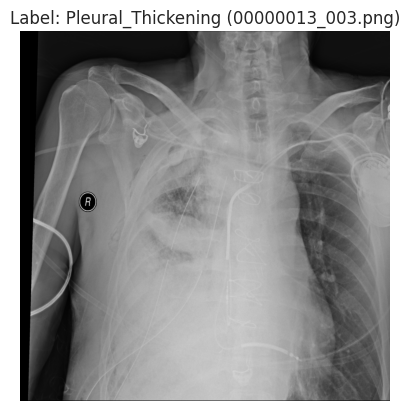

Q: Identify all abnormalities in the given chest X-ray.

A: Atelectasis, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Atelectasis, lobar/segmental collapse, lung opacity, pleural effusion, pleural/parenchymal scarring

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Everything else: Tubes] The right chest tube has been removed. [Breathing: Pleura] There is no evidence of 
pneumothorax. [Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence
of pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no 
evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] 
There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. 
[Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence of 
pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no 
evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] 
There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. 
[Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence of 
pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no 
evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. [Breathing: Lungs] 
There is no evidence of pneumomediastinum. [Breathing: Lungs] There is no evidence of pneumomediastinum. 
[Breathing: Lungs] There is no

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

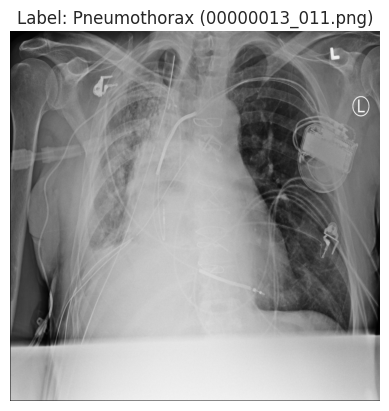

Q: Identify all abnormalities in the given chest X-ray.

A: Atelectasis, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Atelectasis, lung opacity, pleural effusion, pneumothorax

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Everything else: Tubes] The right-sided chest tube has been removed. [Breathing: Pleura] There is no evidence 
of pneumothorax. [Breathing: Lungs] **There is increased opacification of the right hemithorax.** [Breathing: 
Lungs] The left lung is clear. [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The 
mediastinal contours are normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Pleura] 
There is no pleural effusion.

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

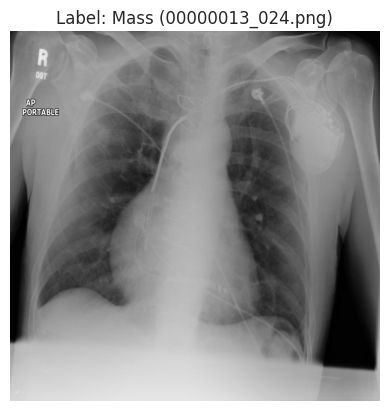

Q: Identify all abnormalities in the given chest X-ray.

A: Enlarged cardiac silhouette, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Enlarged cardiac silhouette

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Cardiac: Heart Size] **The cardiac silhouette is enlarged.** [Breathing: Lungs] There is no evidence of 
vascular congestion. [Breathing: Pleura] There is no pleural effusion. [Breathing: Lungs] There is no acute focal 
pneumonia.

Q: Are there any ground glass opacities?

A: No

----------------------------------------------------------------------------------------------------

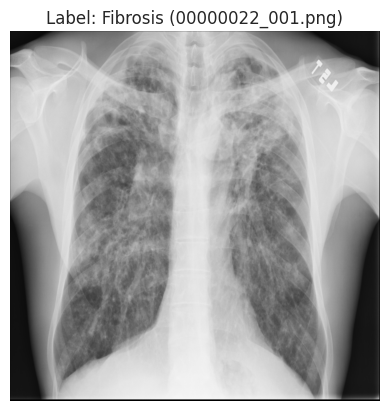

Q: Identify all abnormalities in the given chest X-ray.

A: Atelectasis, linear/patchy atelectasis, lung opacity, pleural/parenchymal scarring

Q: What abnormalities are notable for this patient?

A: Pulmonary fibrosis

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Cardiac: Heart Size] The heart size is normal. [Everything else: Mediastinal] The mediastinal contours are 
normal. [Airway: Hilar Structures] The hilar contours are normal. [Breathing: Lungs] The pulmonary vasculature is 
normal. [Breathing: Lungs] The lungs are hyperinflated but clear. [Breathing: Pleura] No pleural effusion or 
pneumothorax is seen. [Everything else: Bones] There are no acute osseous abnormalities.

Q: Are there any ground glass opacities?

A: Yes

----------------------------------------------------------------------------------------------------

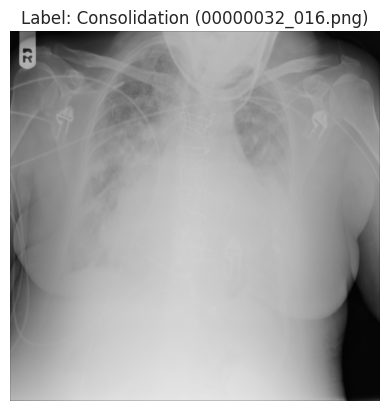

Q: Identify all abnormalities in the given chest X-ray.

A: Enlarged cardiac silhouette, lung opacity, pleural effusion, pulmonary edema/hazy opacity

Q: What abnormalities are notable for this patient?

A: Enlarged cardiac silhouette, lung opacity, pleural effusion, pulmonary edema/hazy opacity

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Everything else: Tubes] The left-sided central venous catheter has been removed. [Breathing: Pleura] There is 
no pneumothorax. [Breathing: Pleura] **There is a small left-sided pleural effusion.** [Breathing: Lungs] **There 
is mild pulmonary edema.** [Cardiac: Heart Size] **The cardiac silhouette is enlarged.** [Everything else: 
Mediastinal] The mediastinal contours are unchanged. [Airway: Hilar Structures] The hilar contours are unchanged. 
[Breathing: Lungs] There is no focal consolidation. [Breathing: Pleura] There is no pneumothorax.

Q: Are there any ground glass opacities?

A: Yes

----------------------------------------------------------------------------------------------------

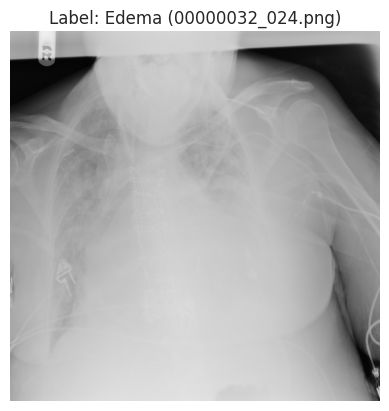

Q: Identify all abnormalities in the given chest X-ray.

A: Enlarged cardiac silhouette, lung opacity, pleural effusion, pulmonary edema/hazy opacity

Q: What abnormalities are notable for this patient?

A: Enlarged cardiac silhouette, lung opacity, pleural effusion, pulmonary edema/hazy opacity

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Everything else: Mediastinal] The cardiomediastinal contours are stable. [Airway: Hilar Structures] The hilar 
contours are stable. [Breathing: Pleura] There is no pneumothorax. [Breathing: Pleura] There is no pleural 
effusion. [Breathing: Lungs] There is no focal consolidation.

Q: Are there any ground glass opacities?

A: Yes

----------------------------------------------------------------------------------------------------

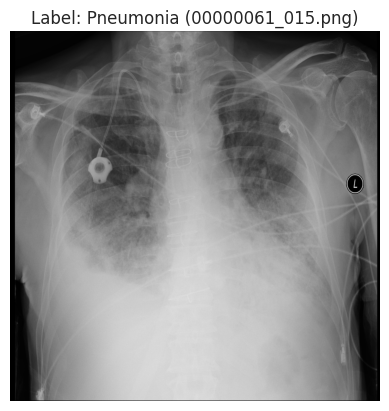

Q: Identify all abnormalities in the given chest X-ray.

A: Atelectasis, lung opacity, pleural effusion

Q: What abnormalities are notable for this patient?

A: Lung opacity, pleural effusion, pulmonary edema/hazy opacity

Q: Write a structured Findings section for the given images as if you are a radiologist.

A: [Everything else: Tubes] The right-sided PICC line has been removed. [Breathing: Pleura] There is no evidence of
pneumothorax. [Breathing: Lungs] **There is a further increase in extent and severity of the pre-existing bilateral
parenchymal opacities.** [Breathing: Pleura] There are no larger pleural effusions. [Cardiac: Heart Size] The size 
of the cardiac silhouette is unchanged.

Q: Are there any ground glass opacities?

A: Yes

----------------------------------------------------------------------------------------------------

In [20]:
warnings.filterwarnings("ignore", category=UserWarning)

prompts = [
    "Identify all abnormalities in the given chest X-ray.",
    "What abnormalities are notable for this patient?",
    "Write a structured Findings section for the given images as if you are a radiologist.",
    # "Assess the chest X-ray, identify key findings in the CXR and write a structured findings section.",
    "Are there any ground glass opacities?",
    # "Put a bounding box around regions showing pleural effusion?"
]

for _, row in subset.iterrows():
    images = [Image.open(row["image_path"]).convert("RGB")]
    img_name, label = row["image_index"], row["finding_labels"]
    title = f"Label: {label} ({img_name})"
    plot_img(image=images[0], title=title)
    for prompt in prompts:
        response = generate(images, prompt, processor, model, device, dtype, generation_config)
        print(f"Q: {prompt}\n\nA: {response}\n\n")
    print("-" * 100)

warnings.resetwarnings()